## Training VAE Autoencoder with ignition events (1)

**Status:** PUBLIC Distribution <br>
**File Name:** 01_Autoencoder_training_ignition_events(1).ipynb

**Author:** Jaume Manero / Darshana Upadhyay / Richard Purcell<br> 
**Date created:** 2023/06/19<br>
**Last modified:** 2023/06/19<br>
**Description:** Autoencoders for Forest Fire prediction

We train an autoencoder with a file with Ignition events. This is the first notebook. In this notebook we train the autoencoder to recognize ignition events. There is a map visualization of ignition events in BC

This version uses MinMaxScaler

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras.optimizers.legacy import SGD,Adam,RMSprop
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Hyperparameters



In [3]:
path_ignition = './Data/ignition_rows.csv'
path_non_ignition = './Data/non_ignition_rows.csv'
ignition_df = pd.read_csv(path_ignition)  
non_ignition_df = pd.read_csv(path_non_ignition, nrows=1000000)  
ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [4]:
non_ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [5]:
ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)
non_ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)

In [6]:
# we create a numpy array with the features of every row
ignition_np = ignition_df.to_numpy()
print('ignition shape',ignition_np.shape)
non_ignition_np = non_ignition_df.to_numpy()
print('non_ignition shape',non_ignition_np.shape)

ignition shape (51918, 22)
non_ignition shape (1000000, 22)


In [7]:
ignition_df = ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = PowerTransformer()
ignition_scaled = scaler.fit_transform(ignition_df)
ignition_scaled.shape

(51918, 22)

In [8]:
non_ignition_df = non_ignition_df.replace([np.inf, -np.inf], 0)

#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = PowerTransformer()
non_ignition_scaled = scaler.fit_transform(non_ignition_df)
non_ignition_scaled.shape

(1000000, 22)

In [9]:
# generate train set
# training set will consist of ignition dataset

len_ignition = len(ignition_scaled)
len_ignition_train = int(0.80 * len_ignition)
X_train = ignition_scaled[:len_ignition_train]
X_train.shape

(41534, 22)

In [10]:
# generate non-ignition set
# test will be only non-ignition data (much larger)

len_non_ignition = len(non_ignition_scaled)
X_test = non_ignition_scaled
X_test.shape

(1000000, 22)

In [11]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_train)))
X_train = np.nan_to_num(X_train)

1653


In [12]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_test)))
X_test = np.nan_to_num(X_test)
# y_test.shape

1988597


In [13]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(np.abs(v1 - v2), axis=1)

In [14]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 4)
intermediate_dim = 32
latent_dim = 4

In [16]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 22)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           736         ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 16)           528         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 16)           272         ['dense_1[0][0]']                
                                                                                            

In [17]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim/2, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim, activation='relu')(x)
x             = Dense(intermediate_dim, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 22)                726       
                                                                 
Total params: 2,406
Trainable params: 2,406
Non-trainable params: 0
_________________________________________________________________


In [18]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [19]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 22)]              0         
                                                                 
 encoder (Functional)        (None, 4)                 1672      
                                                                 
 decoder (Functional)        (None, 22)                2406      
                                                                 
Total params: 4,078
Trainable params: 4,078
Non-trainable params: 0
_________________________________________________________________
Train on 41534 samples
Epoch 1/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 90.3430
Epoch 2/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 50.5202
Epoch 3/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 35.9819
Epoch 4/5000
41534/41534 

41534/41534 [==============================] - 0s 12us/sample - loss: 21.5811
Epoch 82/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 21.6335
Epoch 83/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 21.6095
Epoch 84/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.5569
Epoch 85/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 21.5792
Epoch 86/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 21.5569
Epoch 87/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5322
Epoch 88/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 21.5357
Epoch 89/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 21.5525
Epoch 90/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 21.6006
Epoch 91/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 21.5290
Ep

41534/41534 [==============================] - 0s 12us/sample - loss: 20.6560
Epoch 170/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.6042
Epoch 171/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.6369
Epoch 172/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.5929
Epoch 173/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.5601
Epoch 174/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.6394
Epoch 175/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.6376
Epoch 176/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.5482
Epoch 177/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.5624
Epoch 178/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.6510
Epoch 179/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 

41534/41534 [==============================] - 0s 12us/sample - loss: 20.2024
Epoch 258/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.3010
Epoch 259/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.1861
Epoch 260/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.2141
Epoch 261/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.4438
Epoch 262/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.1380
Epoch 263/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.3577
Epoch 264/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.2475
Epoch 265/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.2015
Epoch 266/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.3236
Epoch 267/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 

41534/41534 [==============================] - 0s 12us/sample - loss: 20.0230
Epoch 346/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.0163
Epoch 347/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.1752
Epoch 348/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.1057
Epoch 349/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.0548
Epoch 350/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.0007
Epoch 351/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.9820
Epoch 352/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 20.1432
Epoch 353/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.9467
Epoch 354/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.0401
Epoch 355/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 

41534/41534 [==============================] - 0s 12us/sample - loss: 19.9402
Epoch 434/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.8688
Epoch 435/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.1661
Epoch 436/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.9679
Epoch 437/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.9002
Epoch 438/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.9277
Epoch 439/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.9812
Epoch 440/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.0795
Epoch 441/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.5884
Epoch 442/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.6852
Epoch 443/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 

41534/41534 [==============================] - 0s 12us/sample - loss: 19.7698
Epoch 522/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.7968
Epoch 523/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.8810
Epoch 524/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.9684
Epoch 525/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.8746
Epoch 526/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.7271
Epoch 527/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.8340
Epoch 528/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.9312
Epoch 529/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 20.0035
Epoch 530/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.9512
Epoch 531/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 

41534/41534 [==============================] - 0s 11us/sample - loss: 19.5861
Epoch 610/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.6772
Epoch 611/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.8857
Epoch 612/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.6936
Epoch 613/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.6400
Epoch 614/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.6846
Epoch 615/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.7733
Epoch 616/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.1173
Epoch 617/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.6664
Epoch 618/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.7065
Epoch 619/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 

41534/41534 [==============================] - 1s 20us/sample - loss: 19.4856
Epoch 698/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 19.4252
Epoch 699/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 19.7665
Epoch 700/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 19.8244
Epoch 701/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 19.9744
Epoch 702/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 19.7564
Epoch 703/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 19.6730
Epoch 704/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 19.4715
Epoch 705/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 19.5443
Epoch 706/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 19.4626
Epoch 707/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 

41534/41534 [==============================] - 0s 11us/sample - loss: 19.4101
Epoch 786/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4483
Epoch 787/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3953
Epoch 788/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3563
Epoch 789/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3327
Epoch 790/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4002
Epoch 791/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3214
Epoch 792/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2983
Epoch 793/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.6111
Epoch 794/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4038
Epoch 795/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 

41534/41534 [==============================] - 0s 12us/sample - loss: 19.1097
Epoch 874/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.2767
Epoch 875/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4400
Epoch 876/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2766
Epoch 877/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3553
Epoch 878/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.1308
Epoch 879/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.1180
Epoch 880/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.1173
Epoch 881/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2102
Epoch 882/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 19.2417
Epoch 883/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 

41534/41534 [==============================] - 0s 12us/sample - loss: 19.0641
Epoch 962/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.9832
Epoch 963/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.1586
Epoch 964/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9866
Epoch 965/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.0411
Epoch 966/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0227
Epoch 967/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0015
Epoch 968/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9909
Epoch 969/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0413
Epoch 970/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.9997
Epoch 971/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 

41534/41534 [==============================] - 0s 12us/sample - loss: 19.0441
Epoch 1049/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3970
Epoch 1050/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.9370
Epoch 1051/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9353
Epoch 1052/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0003
Epoch 1053/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0438
Epoch 1054/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.9424
Epoch 1055/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.9115
Epoch 1056/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9009
Epoch 1057/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9482
Epoch 1058/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.9286
Epoch 1136/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.8431
Epoch 1137/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.8227
Epoch 1138/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.9431
Epoch 1139/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7728
Epoch 1140/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9051
Epoch 1141/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7907
Epoch 1142/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.7853
Epoch 1143/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7449
Epoch 1144/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.8088
Epoch 1145/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.7052
Epoch 1223/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0505
Epoch 1224/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.8569
Epoch 1225/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7059
Epoch 1226/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7968
Epoch 1227/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9291
Epoch 1228/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6738
Epoch 1229/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7063
Epoch 1230/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.8365
Epoch 1231/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.7016
Epoch 1232/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.7740
Epoch 1310/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6240
Epoch 1311/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.8223
Epoch 1312/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.8808
Epoch 1313/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6264
Epoch 1314/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6013
Epoch 1315/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6132
Epoch 1316/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6590
Epoch 1317/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5882
Epoch 1318/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6291
Epoch 1319/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.9068
Epoch 1397/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7026
Epoch 1398/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5219
Epoch 1399/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6596
Epoch 1400/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5680
Epoch 1401/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6713
Epoch 1402/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5776
Epoch 1403/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6137
Epoch 1404/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6329
Epoch 1405/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5798
Epoch 1406/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.6017
Epoch 1484/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6674
Epoch 1485/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5103
Epoch 1486/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5192
Epoch 1487/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5991
Epoch 1488/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6461
Epoch 1489/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6111
Epoch 1490/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5826
Epoch 1491/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7132
Epoch 1492/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6344
Epoch 1493/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.5258
Epoch 1571/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6646
Epoch 1572/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6058
Epoch 1573/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5321
Epoch 1574/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5025
Epoch 1575/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5237
Epoch 1576/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5416
Epoch 1577/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6724
Epoch 1578/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.8464
Epoch 1579/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9011
Epoch 1580/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.5170
Epoch 1658/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5811
Epoch 1659/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6544
Epoch 1660/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6361
Epoch 1661/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6733
Epoch 1662/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5444
Epoch 1663/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4828
Epoch 1664/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5199
Epoch 1665/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4955
Epoch 1666/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5667
Epoch 1667/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.7490
Epoch 1745/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5808
Epoch 1746/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 18.6125
Epoch 1747/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9100
Epoch 1748/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.7629
Epoch 1749/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 18.7263
Epoch 1750/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5862
Epoch 1751/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0294
Epoch 1752/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0575
Epoch 1753/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.9093
Epoch 1754/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.4312
Epoch 1832/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5758
Epoch 1833/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4801
Epoch 1834/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6097
Epoch 1835/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4496
Epoch 1836/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4934
Epoch 1837/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4841
Epoch 1838/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6781
Epoch 1839/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4412
Epoch 1840/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4957
Epoch 1841/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.4388
Epoch 1919/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4649
Epoch 1920/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5992
Epoch 1921/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4307
Epoch 1922/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6219
Epoch 1923/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6811
Epoch 1924/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5960
Epoch 1925/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4606
Epoch 1926/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5353
Epoch 1927/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4566
Epoch 1928/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.5067
Epoch 2006/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5362
Epoch 2007/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3911
Epoch 2008/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4529
Epoch 2009/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4176
Epoch 2010/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5136
Epoch 2011/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4743
Epoch 2012/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6530
Epoch 2013/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3643
Epoch 2014/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3837
Epoch 2015/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 19.3363
Epoch 2093/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3221
Epoch 2094/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.2985
Epoch 2095/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.2858
Epoch 2096/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 19.4680
Epoch 2097/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4385
Epoch 2098/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4568
Epoch 2099/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3140
Epoch 2100/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.2521
Epoch 2101/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2666
Epoch 2102/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.4756
Epoch 2180/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5068
Epoch 2181/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5713
Epoch 2182/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4663
Epoch 2183/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5946
Epoch 2184/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4881
Epoch 2185/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5023
Epoch 2186/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4299
Epoch 2187/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5641
Epoch 2188/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6814
Epoch 2189/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.4032
Epoch 2267/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4237
Epoch 2268/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4000
Epoch 2269/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4705
Epoch 2270/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7671
Epoch 2271/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.5875
Epoch 2272/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0987
Epoch 2273/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 18.5665
Epoch 2274/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 18.6253
Epoch 2275/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4972
Epoch 2276/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.3713
Epoch 2354/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5789
Epoch 2355/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.8546
Epoch 2356/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.7432
Epoch 2357/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4518
Epoch 2358/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5405
Epoch 2359/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4128
Epoch 2360/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.1534
Epoch 2361/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4717
Epoch 2362/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 18.4230
Epoch 2363/5000
41534/41534 [==============================] - 1s 12us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.3789
Epoch 2441/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3659
Epoch 2442/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4834
Epoch 2443/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4257
Epoch 2444/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4335
Epoch 2445/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4694
Epoch 2446/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3716
Epoch 2447/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5674
Epoch 2448/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3949
Epoch 2449/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5521
Epoch 2450/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 1s 12us/sample - loss: 19.4663
Epoch 2528/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6295
Epoch 2529/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4735
Epoch 2530/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4528
Epoch 2531/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4287
Epoch 2532/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3954
Epoch 2533/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4576
Epoch 2534/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5269
Epoch 2535/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4441
Epoch 2536/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3591
Epoch 2537/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.4737
Epoch 2615/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4837
Epoch 2616/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3767
Epoch 2617/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4030
Epoch 2618/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5034
Epoch 2619/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5665
Epoch 2620/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4978
Epoch 2621/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.7712
Epoch 2622/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3515
Epoch 2623/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3416
Epoch 2624/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.7742
Epoch 2702/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5525
Epoch 2703/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4167
Epoch 2704/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.8131
Epoch 2705/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6035
Epoch 2706/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3625
Epoch 2707/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2917
Epoch 2708/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3248
Epoch 2709/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3242
Epoch 2710/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4585
Epoch 2711/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.4067
Epoch 2789/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4110
Epoch 2790/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2725
Epoch 2791/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3913
Epoch 2792/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2608
Epoch 2793/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2484
Epoch 2794/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2787
Epoch 2795/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3020
Epoch 2796/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2986
Epoch 2797/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6119
Epoch 2798/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.2626
Epoch 2876/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2625
Epoch 2877/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2766
Epoch 2878/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3269
Epoch 2879/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5540
Epoch 2880/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2522
Epoch 2881/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3176
Epoch 2882/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2421
Epoch 2883/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3679
Epoch 2884/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3972
Epoch 2885/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.7956
Epoch 2963/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4020
Epoch 2964/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3575
Epoch 2965/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3423
Epoch 2966/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3930
Epoch 2967/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4544
Epoch 2968/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4164
Epoch 2969/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2347
Epoch 2970/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2546
Epoch 2971/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5172
Epoch 2972/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.2718
Epoch 3050/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2284
Epoch 3051/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3775
Epoch 3052/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.5111
Epoch 3053/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4235
Epoch 3054/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4198
Epoch 3055/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4041
Epoch 3056/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.5016
Epoch 3057/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.4546
Epoch 3058/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.6311
Epoch 3059/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 19.3866
Epoch 3137/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3511
Epoch 3138/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3488
Epoch 3139/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2586
Epoch 3140/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.2147
Epoch 3141/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2373
Epoch 3142/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3663
Epoch 3143/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2718
Epoch 3144/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2120
Epoch 3145/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3545
Epoch 3146/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 19.1622
Epoch 3224/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 19.2104
Epoch 3225/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 19.2724
Epoch 3226/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 19.3229
Epoch 3227/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 19.4757
Epoch 3228/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 19.5443
Epoch 3229/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.5446
Epoch 3230/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.6988
Epoch 3231/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2346
Epoch 3232/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.1266
Epoch 3233/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.4867
Epoch 3311/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1805
Epoch 3312/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2534
Epoch 3313/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1958
Epoch 3314/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1674
Epoch 3315/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2478
Epoch 3316/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3466
Epoch 3317/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2443
Epoch 3318/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6158
Epoch 3319/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0984
Epoch 3320/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 19.4982
Epoch 3398/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2437
Epoch 3399/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.2477
Epoch 3400/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.1976
Epoch 3401/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.1116
Epoch 3402/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.2474
Epoch 3403/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.5821
Epoch 3404/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3025
Epoch 3405/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.1575
Epoch 3406/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.0907
Epoch 3407/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.1941
Epoch 3485/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1714
Epoch 3486/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 18.2124
Epoch 3487/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 18.2176
Epoch 3488/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2511
Epoch 3489/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1169
Epoch 3490/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1544
Epoch 3491/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2937
Epoch 3492/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5615
Epoch 3493/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5350
Epoch 3494/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.2067
Epoch 3572/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2783
Epoch 3573/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1117
Epoch 3574/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1140
Epoch 3575/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3994
Epoch 3576/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3005
Epoch 3577/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.8839
Epoch 3578/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1411
Epoch 3579/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1499
Epoch 3580/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1549
Epoch 3581/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.1525
Epoch 3659/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2744
Epoch 3660/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2533
Epoch 3661/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1714
Epoch 3662/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1314
Epoch 3663/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1863
Epoch 3664/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1276
Epoch 3665/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1876
Epoch 3666/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2915
Epoch 3667/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1342
Epoch 3668/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.1793
Epoch 3746/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2237
Epoch 3747/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4526
Epoch 3748/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.0624
Epoch 3749/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1033
Epoch 3750/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1041
Epoch 3751/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.8561
Epoch 3752/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1421
Epoch 3753/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1248
Epoch 3754/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.0644
Epoch 3755/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.1494
Epoch 3833/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1774
Epoch 3834/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2718
Epoch 3835/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2591
Epoch 3836/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3134
Epoch 3837/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1891
Epoch 3838/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2255
Epoch 3839/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2937
Epoch 3840/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2166
Epoch 3841/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2774
Epoch 3842/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.2398
Epoch 3920/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1270
Epoch 3921/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0846
Epoch 3922/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0774
Epoch 3923/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1515
Epoch 3924/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1866
Epoch 3925/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3545
Epoch 3926/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7360
Epoch 3927/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3918
Epoch 3928/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.4432
Epoch 3929/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.6159
Epoch 4007/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4478
Epoch 4008/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4130
Epoch 4009/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2896
Epoch 4010/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1846
Epoch 4011/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0762
Epoch 4012/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1558
Epoch 4013/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.0863
Epoch 4014/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1618
Epoch 4015/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2567
Epoch 4016/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.1090
Epoch 4094/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0573
Epoch 4095/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 631920.0182
Epoch 4096/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 21.7253
Epoch 4097/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3397
Epoch 4098/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.9192
Epoch 4099/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6886
Epoch 4100/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6488
Epoch 4101/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4824
Epoch 4102/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4939
Epoch 4103/5000
41534/41534 [==============================] - 0s 11us/s

41534/41534 [==============================] - 0s 11us/sample - loss: 18.2841
Epoch 4181/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3486
Epoch 4182/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3273
Epoch 4183/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.3265
Epoch 4184/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.3109
Epoch 4185/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 20.0241
Epoch 4186/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 19.4432
Epoch 4187/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.7097
Epoch 4188/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5117
Epoch 4189/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5100
Epoch 4190/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.2739
Epoch 4268/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4006
Epoch 4269/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2444
Epoch 4270/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3406
Epoch 4271/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5311
Epoch 4272/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6385
Epoch 4273/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4029
Epoch 4274/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4061
Epoch 4275/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2192
Epoch 4276/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5991
Epoch 4277/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.3687
Epoch 4355/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2217
Epoch 4356/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2840
Epoch 4357/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1248
Epoch 4358/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4665
Epoch 4359/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2527
Epoch 4360/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.5009
Epoch 4361/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5181
Epoch 4362/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4035
Epoch 4363/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4086
Epoch 4364/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.1705
Epoch 4442/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 18.1531
Epoch 4443/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 18.1178
Epoch 4444/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 18.0578
Epoch 4445/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 18.0556
Epoch 4446/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 18.2519
Epoch 4447/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 19.5929
Epoch 4448/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 19.6225
Epoch 4449/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 18.9287
Epoch 4450/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 18.6909
Epoch 4451/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.0420
Epoch 4529/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0996
Epoch 4530/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0870
Epoch 4531/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0893
Epoch 4532/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1009
Epoch 4533/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2233
Epoch 4534/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1351
Epoch 4535/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0946
Epoch 4536/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.0396
Epoch 4537/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1857
Epoch 4538/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.2742
Epoch 4616/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2563
Epoch 4617/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2990
Epoch 4618/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3027
Epoch 4619/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4082
Epoch 4620/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.6080
Epoch 4621/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5203
Epoch 4622/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 18.6301
Epoch 4623/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 18.7229
Epoch 4624/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6331
Epoch 4625/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.3312
Epoch 4703/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 23.1016
Epoch 4704/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 19.0413
Epoch 4705/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5402
Epoch 4706/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.4297
Epoch 4707/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3638
Epoch 4708/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3571
Epoch 4709/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3198
Epoch 4710/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.3192
Epoch 4711/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2904
Epoch 4712/5000
41534/41534 [==============================] - 0s 12us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.2839
Epoch 4790/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.0852
Epoch 4791/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2049
Epoch 4792/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3114
Epoch 4793/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2341
Epoch 4794/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1044
Epoch 4795/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1601
Epoch 4796/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1113
Epoch 4797/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1876
Epoch 4798/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.6344
Epoch 4799/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 12us/sample - loss: 18.0942
Epoch 4877/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3029
Epoch 4878/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1853
Epoch 4879/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 18.4989
Epoch 4880/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.7018
Epoch 4881/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.7103
Epoch 4882/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.4756
Epoch 4883/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.2558
Epoch 4884/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5002
Epoch 4885/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.1231
Epoch 4886/5000
41534/41534 [==============================] - 0s 11us/sampl

41534/41534 [==============================] - 0s 11us/sample - loss: 18.2072
Epoch 4964/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.0312
Epoch 4965/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.0343
Epoch 4966/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2240
Epoch 4967/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 18.8054
Epoch 4968/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.5762
Epoch 4969/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1601
Epoch 4970/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.2127
Epoch 4971/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.3160
Epoch 4972/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 18.1888
Epoch 4973/5000
41534/41534 [==============================] - 0s 11us/sampl

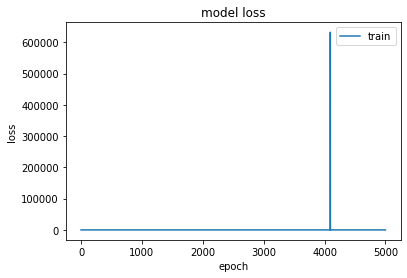

INFO:tensorflow:Assets written to: ./Data/vae_model.hf5/assets


INFO:tensorflow:Assets written to: ./Data/vae_model.hf5/assets


In [20]:
opt = RMSprop(learning_rate=0.0001)
opt = Adam(learning_rate=0.00001, clipvalue=0.5)
opt = Adam()


vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

trained = False     # First time train / Next times use saved model to speed up analysis
if trained:
    vae_model = load_model('./Data/vae_model.hf5', custom_objects={'vae_loss': vae_loss})

else:
    results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=5000,
                        batch_size=128)
    # Training figure
    plt.plot(results.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    # saving weights
    vae_model.save('./Data/vae_model.hf5')

In [21]:
X_train_pred = vae_model.predict(X_train)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
mae_vector_train = get_error_term(X_train_pred, X_train, _rmse=False)

print(f'Avg error {np.mean(mae_vector_train)}\nmedian error {np.median(mae_vector_train)}\n99Q:    \
      {np.quantile(mae_vector_train, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector_train, 0.99)} ')

error_thresh = np.quantile(mae_vector_train, 0.99)
error_thresh = np.quantile(mae_vector_train, 0.995)
error_median = np.quantile(mae_vector_train, 0.5)
print(error_thresh, error_median)

Avg error 0.044442677017084285
median error 0.04313863617477731
99Q:          0.07808167400253499
setting threshold on 0.07808167400253499 
0.0842342908578012 0.04313863617477731


<AxesSubplot:title={'center':'Distribution Plot reconstruction error ignitions'}, ylabel='Count'>

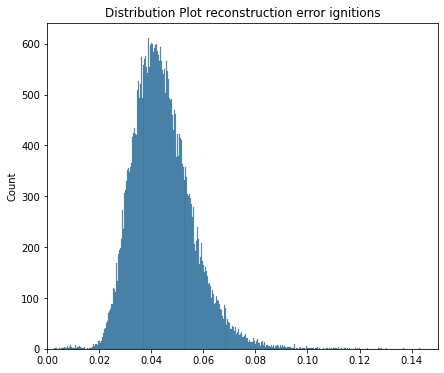

In [35]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title('Distribution Plot reconstruction error ignitions')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim(0,0.15)
#plt.ylim(0,50)
sns.histplot(data=mae_vector_train, bins = 1000)

In [24]:
X_pred_test = vae_model.predict(X_test)
print('threshold', error_thresh,error_median)
#train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

mae_vector = get_error_term(X_pred_test, X_test, _rmse=False)
anomalies = (mae_vector > error_median)

np.count_nonzero(anomalies) / len(anomalies)
print('total non_ignitions',len(X_pred_test))
print('number of almost_ignitions', np.count_nonzero(anomalies==0))

#print('total y_test',len(y_test))
#print(np.count_nonzero(y_test))

threshold 0.0842342908578012 0.04313863617477731
total non_ignitions 1000000
number of almost_ignitions 187570


In [25]:
mae_vector

array([0.04874763, 0.0475427 , 0.07042913, ..., 0.06770077, 0.09346824,
       0.0633128 ])

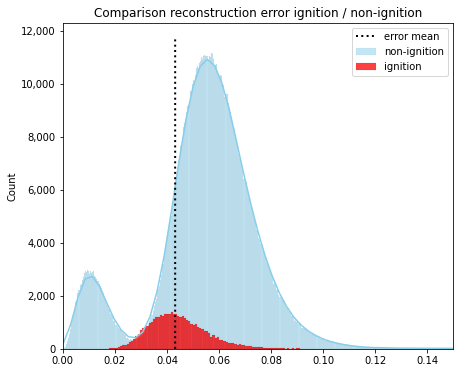

In [40]:
fig,ax  = plt.subplots(figsize=(7,6))
sns.histplot(data=mae_vector, ax=ax, color='skyblue', label='non-ignition', kde=True)
sns.histplot(data=mae_vector_train, ax=ax, color='red', label='ignition')
xmin, xmax, ymin, ymax = plt.axis()
liney = np.arange(ymin, ymax, 0.01)
linex = np.ones(len(liney)) * error_median
sns.lineplot(x = linex, y= liney, color='black', ax=ax, linewidth=2, estimator = None, 
             linestyle='dotted', label='error mean')
ax.set_title('Comparison reconstruction error ignition / non-ignition')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim(0,0.15)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [27]:
error_thresh_low = np.quantile(mae_vector_train, 0.33)
error_thresh_high = np.quantile(mae_vector_train, 0.66)
print(error_thresh_low,error_thresh_high)
near_ignitions = (mae_vector > error_thresh_low )
near_ignitions = ((mae_vector > error_thresh_low) &(mae_vector < error_thresh_high))
near_ignitions = near_ignitions*1 # trick to have near_ignitions as 1 and ignitions as 0

0.0386498070382427 0.04777303756729463


In [28]:
near_ignitions

array([0, 1, 0, ..., 0, 0, 0])

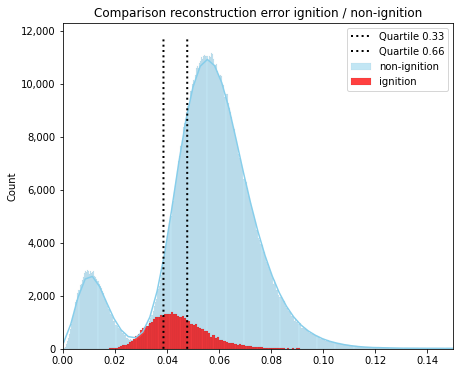

In [41]:
fig,ax  = plt.subplots(figsize=(7,6))
sns.histplot(data=mae_vector, ax=ax, color='skyblue', label='non-ignition', kde=True)
sns.histplot(data=mae_vector_train, ax=ax, color='red', label='ignition')
xmin, xmax, ymin, ymax = plt.axis()
liney = np.arange(ymin, ymax, 0.01)
linex = np.ones(len(liney)) * error_thresh_low
sns.lineplot(x = linex, y= liney, color='black', ax=ax, linewidth=2, estimator = None, 
             linestyle = 'dotted', label='Quartile 0.33')
linex = np.ones(len(liney))* error_thresh_high
sns.lineplot(x = linex, y= liney, color='black', ax=ax, linewidth=1, estimator = None, 
             linestyle = 'dashed', label='Quartile 0.66')
ax.set_title('Comparison reconstruction error ignition / non-ignition')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim(0,0.15)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [30]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = vae_model.predict(X_test)
# PCA transformation to observe variance in 2 components

pca = PCA(n_components=3)
X_transform = pca.fit_transform(X_pred2)

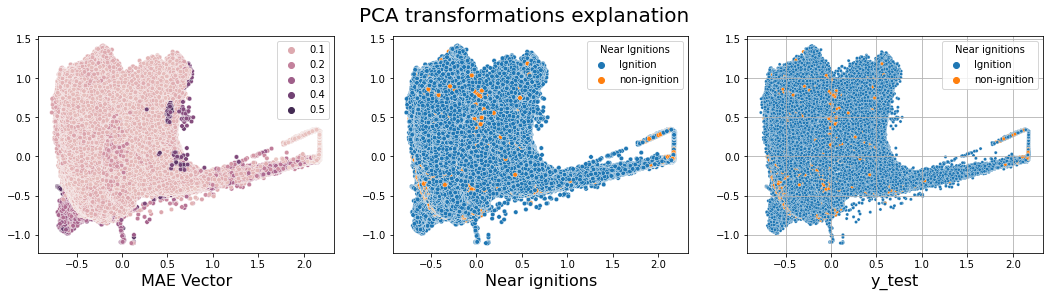

In [31]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations explanation',size=20)

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=near_ignitions, ax=ax2)
ax2.set_xlabel('Near ignitions', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Ignition', 'non-ignition'], title='Near Ignitions')

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=near_ignitions, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Ignition', 'non-ignition'], title='Near ignitions')

plt.grid()
plt.show()

In [32]:
#===== program ends here. now create a new label and label non-ignition dataset with new class ===== #

In [33]:
import session_info
session_info.show(html=False)

-----
keras               2.12.0
matplotlib          3.5.0
numpy               1.22.4
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
sklearn             1.2.1
tensorflow          2.12.0
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-45-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-06-26 09:49


### 